## Introduction

<img src="https://i.imgur.com/Tko46mp.png" width="1000" style="display:block; margin:auto" />

In mid-June 2022, Pakistan began experiencing unusually heavy rainfall. Within weeks, the relentless downpours had led to widespread flooding across significant parts of the country. Pakistan's climate is characterized by a distinct monsoon season, with the majority of its annual rainfall, approximately 70-75%, occurring between June and September. However, the intensity of these monsoon rains varies annually, with some years witnessing far higher rainfall than usual.

In 2022, the monsoon season was exceptionally severe. Described by U.N. Secretary-General António Guterres as a "monsoon on steroids,” Pakistan received about ten times more rain than its average. Some regions were particularly hard-hit, receiving 600-800% percent of their typical August rainfall. At the peak of this crisis, Sindh, the country's most populous province, saw an overwhelming 15 inches of rain in just one day. As the summer progressed, these waters accumulated in the low-lying areas surrounding the Indus River, transforming vast stretches of farmland into virtual lakes and isolating numerous villages.

The catastrophic floods resulted in a tragic loss of life and widespread devastation. A total of 1,739 individuals lost their lives, including 647 children, and there were 12,867 reported injuries. The disaster left over 2.1 million people without homes, marking it as the most severe flood in Pakistan since 2010, which had a death toll of nearly 2,000. These floods were also the most catastrophic globally since the South Asian floods in 2020. 

Synthetic Aperture Radar (SAR) offers several significant advantages for flood mapping, making it a highly effective tool in disaster management and environmental monitoring. Unlike optical sensors, SAR can penetrate through clouds and is not affected by weather conditions. This feature is particularly crucial for flood mapping, as heavy cloud cover often accompanies flooding events. Additionally, SAR systems can operate effectively both day and night, ensuring continuous monitoring of flood situations. Lastly, SAR is particularly sensitive to smooth surfaces like water, which appear dark on SAR images. This contrast makes it easier to differentiate between flooded and non-flooded areas, enhancing the accuracy of flood extent mapping.

The following tutorial is based upon a [UN-SPIDER Google Earth Engine (GEE) JavaScript Script](https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-google-earth-engine-flood-mapping/step-by-step) for flood mapping. It has been translated to Python, heavily adapted, and expanded. 

Let's get started... 

<hr>



### 1. Import required packages

Let's start by importing the necessary libraries. The following libraries might be unfamiliar: 

1. **Earth Engine Python API (`ee`)** enables interaction with the Google Earth Engine servers, allowing for complex geospatial computations and access to a vast catalogue of satellite imagery and geospatial datasets.. It allows Google Earth Engine to be used on your local machine without the need to utilise the web-based JavaScript IDE. 

2. **Geemap** facilitates interactive mapping with Google Earth Engine. It's particularly user-friendly for those familiar with Jupyter notebooks and is built on ipyleaflet and folium libraries, providing robust tools for Earth Engine data visualisation and analysis. More info is available here: https://geemap.org/ 

3. **Geopandas** extends the datatypes used by pandas to allow spatial operations on geometric types, making it a powerful library for geospatial analysis.

**Note:** Before running these import statements, you should ensure that these libraries are installed in your Python environment. You can install them using pip or conda if they are not already installed.

In [1]:
# Import required libraries
import ee
import geemap
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import geopandas as gpd
import numpy as np

### 2. Authenticate/initiate Earth Engine Python API

For this tutorial, you'll need an Earth Engine account. If you don't already have one, you can register at [Google Earth Engine Registration](https://code.earthengine.google.com/register)

The initial execution of the code will require you to authenticate access to the Earth Engine API. The steps are: 

1. **Run the Authentication Code:** When you run the authentication code segment for the first time, a new browser window will pop up.

2. **Follow the Authentication Steps:** In the browser, you'll be guided through a series of steps to authenticate your Earth Engine account. This involves signing in with your Google account credentials and granting necessary permissions.

3. **Copy the Authentication Code:** On successful authentication, you'll receive an authentication code. Copy this code.

4. **Paste the Code in the notebook:** Return to this notebook. A prompt or input box will appear requesting the authentication code. Paste the code you copied into this box and submit.

Once these steps are complete, the Earth Engine API will be authenticated, and you'll be able to run the code segments in this tutorial. This is a one-time process.

In [2]:
# Authenticate/initiate Earth Engine Python API
try:
    # Attempt to initialize the Earth Engine API.
    ee.Initialize()
    print("Earth Engine API successfully initialized.")
except:
    # If initialization fails, authenticate and then initialize.
    print("You are not authenticated. Running authentication now...")
    ee.Authenticate()
    ee.Initialize()
    print("Authentication successful. Earth Engine API successfully initialized.")

Earth Engine API successfully initialized.


### 3. Define AOI and load ADM2 (division) boundaries

Here we define our Area of Interest (AOI) using a bounding box. This AOI was chosen based on reports of which regions were most affected by the 2022 foods. 

The AOI:

<img src="https://i.imgur.com/Np3zgQl.png" width="700" />

Administrative boundary data for ADM2 level (divisions) are imported from a Google Earth Engine (GEE) asset and clipped to our AOI. The purpose of this data is to facilitate the extraction of division-level flood statistics in subsequent analysis steps.

In [3]:
# Define AOI bounding box
aoi = ee.Geometry.Polygon([
    [66.60903973281872,23.261545926289028],
    [70.48721356094372,23.261545926289028],
    [70.48721356094372,29.286410056079323],
    [66.60903973281872,29.286410056079323]])

# Import Pakistan adm2 boundaries from GEE assets (to be used for flood statistics)
adm2 = (ee.FeatureCollection('projects/ee-swcoughlan/assets/pak_adm2')
          .filterBounds(aoi))

### 4. Define date ranges for before and after the flood

The objective here is to capture comparative snapshots before and after the flood to evaluate the extent of inundation. For this, I've selected month-long intervals as reference periods for the `before` and `after` scenarios. Typically, March through May are dry months in Pakistan, preceding the onset of the monsoon season, which extends from early June to September. The 2022 floods, notably starting around June 14th, persisted until September's end.

Ensure the ranges are long enough to acquire a sufficient number of tiles for your AOI. This will vary depending on AOI size and location, and you might have to play with the dates. 

In [4]:
# Before the flood
before_start= '2022-03-15'
before_end='2022-04-15'

# After the flood
after_start='2022-08-15'
after_end='2022-09-15'

# Print date range
print("Flooding between:" + " " + after_start + " and " + after_end)

Flooding between: 2022-08-15 and 2022-09-15


### 5. Define water threshold and Sentinel-1 parameters

Set up some key parameters for the analysis:

`water_threshold` is used as a threshold for identifying possible surface water in the SAR imagery. Later, we'll calculate a difference image between 'before' and 'after' and any pixels in that image with a value above this threshold are likely to be classified as water. The value choosen is a general value which works relatively well in dry & wet season. 

`polarization` refers to the polarization of the radar signal used in the Sentinel-1 imagery. Radar signals can be polarized vertically (V) or horizontally (H). 'VH' means that the signal is transmitted vertically and received horizontally. Choice of polarization can affect the ability to detect certain features. 'VH' polarization is often used in flood detection because it's sensitive to changes in surface roughness and can help distinguish water from land.

`orbital_pass` refers to the direction of Sentinel-1's orbit at the time the image was captured. Satellites can capture images on the ascending (from south to north) or descending (from north to south) part of their orbit. Choice of orbital pass can affect the viewing geometry, so for this analysis it's important to only use one orbital direction. You can change this parameter if your image collection doesn't have many images. Some regions have more ascending images than descending and vice versa. 

In [5]:
# Specify the threshold for identifying possible surface water.
# This is a general value which works relatively well in dry & wet season.
water_threshold = 1.19

# Specify polarization(VH or VV) 
polarization = 'VH'

# Specify orbital pass (ASCENDING or DESCENDING)
orbital_pass = 'ASCENDING'

### 6. Required functions

Let's create some necessary functions to be used in subsequent steps. 

#### 6.1. Terrain correction

This function performs terrain correction on Sentinel-1 images. Terrain correction addresses the geometric distortions caused by the side-looking nature of SAR and the varying topography of the Earth's surface. For quantitative analysis, such as change detection or combining SAR data with other types of datasets (like optical imagery, GIS data, etc.), geometric accuracy is crucial. Terrain correction ensures that each pixel in the SAR image accurately represents a specific location on the Earth's surface, facilitating reliable comparisons and analyses. It improves the accuracy, interpretability, and utility of SAR imagery, making it a valuable step in SAR processing. 

In [6]:
# Function to perform terrain correction on Sentinel-1 images
def terrain_correction(image):
    img_geom = image.geometry()
    srtm = ee.Image('USGS/SRTMGL1_003').clip(img_geom)  # 30m SRTM
    sigma0_pow = ee.Image.constant(10).pow(image.divide(10.0))

    # Radar geometry
    theta_i = image.select('angle')
    phi_i = ee.Terrain.aspect(theta_i) \
        .reduceRegion(ee.Reducer.mean(), theta_i.get('system:footprint'), 1000) \
        .get('aspect')

    # Terrain geometry
    alpha_s = ee.Terrain.slope(srtm).select('slope')
    phi_s = ee.Terrain.aspect(srtm).select('aspect')

    # Model geometry
    phi_r = ee.Image.constant(phi_i).subtract(phi_s)

    # Convert all to radians
    phi_r_rad = phi_r.multiply((math.pi) / 180)
    alpha_s_rad = alpha_s.multiply((math.pi) / 180)
    theta_i_rad = theta_i.multiply((math.pi) / 180)
    ninety_rad = ee.Image.constant(90).multiply((math.pi) / 180)

    # Slope steepness in range
    alpha_r = alpha_s_rad.tan().multiply(phi_r_rad.cos()).atan()

    # Slope steepness in azimuth
    alpha_az = alpha_s_rad.tan().multiply(phi_r_rad.sin()).atan()

    # Local incidence angle
    theta_lia = alpha_az.cos().multiply(theta_i_rad.subtract(alpha_r).cos()).acos()
    theta_lia_deg = theta_lia.multiply(180 / math.pi)

    # Gamma nought flat
    gamma0 = sigma0_pow.divide(theta_i_rad.cos())
    gamma0_db = ee.Image.constant(10).multiply(gamma0.log10())
    ratio_1 = gamma0_db.select('VV').subtract(gamma0_db.select('VH'))

    # Volumetric Model
    nominator = ninety_rad.subtract(theta_i_rad).add(alpha_r).tan()
    denominator = ninety_rad.subtract(theta_i_rad).tan()
    vol_model = nominator.divide(denominator).abs()

    # Apply model
    gamma0_volume = gamma0.divide(vol_model)
    gamma0_volume_db = ee.Image.constant(10).multiply(gamma0_volume.log10())

    # Layover/shadow mask
    alpha_r_deg = alpha_r.multiply(180 / math.pi)
    layover = alpha_r_deg.lt(theta_i)

    # Shadow where LIA > 90
    shadow = theta_lia_deg.lt(85)

    # Ratio for RGB visualization
    ratio = gamma0_volume_db.select('VV').subtract(gamma0_volume_db.select('VH'))

    output = gamma0_volume_db.addBands(ratio).addBands(alpha_r).addBands(phi_s).addBands(theta_i_rad) \
        .addBands(layover).addBands(shadow).addBands(gamma0_db).addBands(ratio_1)

    return image.addBands(
        output.select(['VV', 'VH'], ['VV', 'VH']),
        None,
        True
    )

#### 6.2. Cloud mask

This function is designed to eliminate or 'mask' cloud cover from Sentinel-2 images. We'll generate a composite image from Sentinel-2 data, collected over a span of one month, to facilitate a visual comparison between our SAR flood data and the optical imagery obtained from Sentinel-2.

In [7]:
# Function to mask clouds using the Sentinel-2 QA band
def mask_s2_clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0) \
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))

    return image.updateMask(mask).divide(1e4)

#### 6.3. Normalized Difference Water Index (NDWI) 

This function adds a Normalized Difference Vegetation Index (NDWI) band to the Sentinel-2 imagery. NDWI is primarily used to monitor vegetation and water content, and is particularly effective at quantifing the presence and extent of water bodies. NDWI is calculated by comparing the reflectance values of near-infrared (NIR) and shortwave infrared (SWIR) bands.

In [8]:
# Function to add Normalized Difference Vegetation Index (NDWI) to Sentinel-2 imagery
def add_ndwi(image):

    # Calculating NDWI using the normalizedDifference function
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    # Add band to the image
    return image.addBands([ndwi])

#### 6.4. Water mask

This function creates an estimated surface water mask

A water mask is created from the before/after difference image, then gradually refined using ancilliary data sets. A binary mask is initially created where pixels with a value greater than the threshold are considered water. Next, the flood mask is refined using the Global Surface Water dataset from the Joint Research Centre (JRC). Perennial water bodies (present more than 10 months of the year) are removed from the flood analysis. The flood mask is further refined by removing pixels connected to 8 or fewer neighbors. This helps to remove isolated pixels that may be noise. Areas with more than 5 percent slope and more than 100m elevation are excluded using a Digital Elevation Model (DEM) from the World Wildlife Fund (WWF) HydroSHEDS dataset. This is based on the assumption that areas with high slope or elevation are less likely to be flooded. Lastly, the flood extent area is calculated by multiplying the flooded mask with the pixel area. The areas of flooded pixels within the AOI are summed and converted to square kilometers and hectares. 

In [9]:
# Function to create estimated surface water mask
def create_water_mask(img, threshold, scale_value):
    # Create water mask image using VV/VH difference (estimated surface water) threshold
    water_mask = img.select('VH').gt(threshold)

    # Refine flood result using additional datasets
    swater = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality')
    swater_mask = swater.gte(10).updateMask(swater.gte(10))
    
    # Flooded layer where perennial water bodies (water > 10 mo/yr) are assigned a 0 value
    flooded_mask = water_mask.where(swater_mask, 0)

    # Final flooded area without pixels in perennial waterbodies
    flooded = flooded_mask.updateMask(flooded_mask)

    # Compute connectivity of pixels to eliminate those connected to 8 or fewer neighbors
    connections = flooded.connectedPixelCount()    
    flooded = flooded.updateMask(connections.gte(8))

    # Mask out areas with > 5% slope and > 100m elevation using a Digital Elevation Model 
    dem = ee.Image('WWF/HydroSHEDS/03VFDEM')
    elevation = dem.select('b1')
    terrain = ee.Algorithms.Terrain(dem)
    slope = terrain.select('slope')
    flooded = flooded.updateMask(slope.lt(5))
    flooded = flooded.updateMask(elevation.lt(100))

    # Calculate flood extent area
    flood_pixelarea = flooded.select('VH').multiply(ee.Image.pixelArea())

    # Sum the areas of flooded pixels
    flood_stats = flood_pixelarea.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=10,  # native Sentinel-1 resolution 
        bestEffort=True
    )

    # Convert the flood extent to square km and hectares
    flood_area_km2 = flood_stats.getNumber('VH').divide(1e6).round()
    flood_area_ha = flood_stats.getNumber('VH').divide(1e4).round()
    
    return flooded, flood_area_km2, flood_area_ha


#### 6.5. Split AOI

This function segments our large AOI into smaller, more manageable tiles. This is intended to avoid processing the whole AOI in one go, which would be computationally intensive and lead to errors during processing. 

In [10]:
# Function to split AOI into smaller tiles.
def split_aoi_into_tiles(aoi, tile_size):
    
    tiles = []

    # Get the bounds of the AOI and extract the coordinates
    bounds = aoi.bounds()
    coords = bounds.coordinates().getInfo()[0]

    # Extract the min and max coordinates
    min_lon = min(coord[0] for coord in coords)
    max_lon = max(coord[0] for coord in coords)
    min_lat = min(coord[1] for coord in coords)
    max_lat = max(coord[1] for coord in coords)

    current_lat = min_lat
    while current_lat < max_lat:
        current_lon = min_lon
        while current_lon < max_lon:
            upper_left = [current_lon, current_lat]
            lower_right = [min(current_lon + tile_size, max_lon),
                           min(current_lat + tile_size, max_lat)]

            # Create a rectangle tile
            tile_coords = [
                upper_left,
                [lower_right[0], upper_left[1]],
                lower_right,
                [upper_left[0], lower_right[1]],
                upper_left  # Closing the loop
            ]

            tile = ee.Geometry.Polygon([tile_coords])
            tiles.append(tile)
            current_lon += tile_size

        current_lat += tile_size

    return tiles

### 7. Load Sentinel-2 

Load the Sentinel-2 imagery for our AOI over a one-month period. Images are filtered to ensure that cloud cover is below 50% and the cloud masking and NDWI functions are applied. 

A composite image is created by averaging the collection and clipping it to the exact dimensions of the AOI. 

In [11]:
# Load Sentinel-2 image collection
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate('2022-08-15', '2022-09-15')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
        .map(mask_s2_clouds)
        .map(add_ndwi)
        .filterBounds(aoi)
        )

# Create a composite and clip to AOI
s2_aoi = s2.mean().clip(aoi)

### 8. Load Sentinel-1 collection, create before & after subsets, apply speckle filter, and calculate the before/after difference. 

Load Sentinel-1 images for our AOI. Images are filtered based on instrument mode, polarization, orbital pass, resolution, and geographic bounds. 

We create two subsets of images, one for the period before and one for after the flood event. Both subsets are processed into mosaics, clipped to the AOI, and smoothed using a speckle filter. 

Finally, we calculate the change between the 'before' and 'after' periods by dividing the smoothed images to create our difference image (to which our flood mask function will be applied).

In [12]:
# Load Sentinel-1 image collection
s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))
        .filter(ee.Filter.eq('orbitProperties_pass', orbital_pass))
        .filter(ee.Filter.eq('resolution_meters', 10))
        .filterBounds(aoi)
        .map(terrain_correction)
        )

# Filter by date
before_collection = s1.select('VH').filterDate(before_start, before_end)
after_collection = s1.select('VH').filterDate(after_start, after_end)

# Function to extract date from metadata
def dates(imgcol):
    range = imgcol.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
    printed = (ee.String('from ')
               .cat(ee.Date(range.get('min')).format('YYYY-MM-dd'))
               .cat(' to ')
               .cat(ee.Date(range.get('max')).format('YYYY-MM-dd')))
    return printed.getInfo()

# Print dates of before images
before_count = before_collection.size().getInfo()
print(f"Tiles selected: Before Flood ({before_count})", dates(before_collection))

# Print dates of after images
after_count = after_collection.size().getInfo()
print(f"Tiles selected: After Flood ({after_count})", dates(after_collection))

# Create a mosaic of selected tiles
before = before_collection.mosaic().clip(aoi)
after = after_collection.mosaic().clip(aoi)

# Apply speckle filter
smoothing_radius = 50
before_smooth = before.focal_mean(smoothing_radius, 'circle', 'meters')
after_smooth = after.focal_mean(smoothing_radius, 'circle', 'meters')

# Calculate difference between before and after
difference = after_smooth.divide(before_smooth)

Tiles selected: Before Flood (33) from 2022-03-17 to 2022-04-12
Tiles selected: After Flood (38) from 2022-08-15 to 2022-09-13


### 9. Create water mask and calculate estimated flooded area

Here we call the `create_water_mask` function to identify potentially flooded areas, using the difference image created in the last step. The function returns the flood mask and the estimated flood area in both square kilometers and hectares. 

In [13]:
# Call the function to create the water mask
flooded_area = create_water_mask(difference, water_threshold, 10)

# Get the flooded area in km2 and hectares
flooded_km2 = flooded_area[1].getInfo()
flooded_ha = flooded_area[2].getInfo()

flooded = flooded_area[0]

# Print the results
print('Total potential flooded area (km2):', flooded_km2)
print('Total potential flooded area (ha):', flooded_ha)

Total potential flooded area (km2): 9440
Total potential flooded area (ha): 944030


### 10. Split the AOI into smaller tiles for processing

Defines a tile size of 10x10km and applies our `split_aoi_into_tiles` function to the AOI.

In [14]:
# Define tile size in meters
tile_size = 10000 # 10km x 10km

# Implements function to split AOI into smaller tiles
tiles = split_aoi_into_tiles(aoi, tile_size) 

### 11. Calculate the estimated number of affected people

It would be useful to have an estimate of the number of people affected by flooding within our AOI. We can use the Global Human Settlement Layer (GHSL) Population Density layer for 2020 for population data. We must first reproject our flood layer to the same projection as the GHSL layer, in order to maintain spatial accuracy. 

Using this reprojected flood layer, we create a new layer indicating the population exposed to flooding by masking the population layer with the flood layer. We then call the `pop_within_tile` function to calculate the sum of the exposed population within each subdivided tile of the AOI, aggregating the values to determine the total exposed population.

In [15]:
# Load JRC GHS-POP R2023A Population Density layer 100m (2020)
# Number of people per cell is returned and aggregated to the AOI
population_count = (ee.Image('JRC/GHSL/P2023A/GHS_POP/2020')
                      .clip(aoi)
                      )

# Get GHSL projection
ghs_projection = population_count.projection()

# Reproject flood layer to GHSL scale
flooded_rpj = flooded.reproject(crs = ghs_projection)

# Create a raster showing exposed population only using the resampled flood layer
population_exposed = population_count.updateMask(flooded_rpj).updateMask(population_count)

# Function to calculate the sum of exposed population within each tile
def pop_within_tile(tile):
    stats = population_exposed.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = tile,
        scale = 100,
        maxPixels = 1e9,
        bestEffort = True
    )
    return stats.getNumber('population_count')

# Apply sum function to each tile
exposed_sums = [pop_within_tile(tile) for tile in tiles] 

# Convert each ee.Number to Python number
exposed_sums_info = [num.getInfo() for num in exposed_sums] 

# Combine results from all tiles
total_exposed_population = round(sum(exposed_sums_info))

# Print result
print('Estimated number of people exposed:', total_exposed_population)

Estimated number of people exposed: 1017688


### 12. Calculate the estimated affected cropland

To assess the impact of flooding on agricultural areas within our AOI, we can utilise the Copernicus Global Land Cover Layer for 2019. Cropland areas are isolated and a mask that highlights agricultural zones is created. The flood layer is again reprojected to align with the land cover projection for spatial accuracy. Using this reprojected flood layer, a new raster is generated to show the cropland areas potentially affected by flooding. The total area of this exposed cropland is calculated in both square kilometers and hectares by summing the pixels within the flood-affected zones. 

In [16]:
# Load Copernicus Global Land Cover Layers: CGLS-LC100 Collection 3 100m (2015-2019)
# Select 'discrete classification' band
landcover = (ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')
               .select("discrete_classification")
               .clip(aoi)
               )

# Extract cropland pixels using the class 'cultivated and managed vegetation / agriculture' (value = 40)
crop_mask = landcover.eq(40)
cropland = landcover.updateMask(crop_mask)

# Get landcover projection
lc_projection = landcover.projection()

# Reproject flood layer to GHSL scale
flooded_rpj = flooded.reproject(crs = lc_projection)

# Create raster of exposed cropland using the resampled flood layer as a mask
cropland_exposed = flooded_rpj.updateMask(cropland)

# Get pixel area of exposed cropland and urban layers
cropland_pixelarea = cropland_exposed.multiply(ee.Image.pixelArea())

# Sum pixels of affected cropland layer
crop_stats = cropland_pixelarea.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi,
    scale=100,
    maxPixels=1e9
)

# Convert area to km2 and hectares
crop_area_km2 = crop_stats.getNumber('VH').divide(1000000).round()
crop_area_ha = crop_stats.getNumber('VH').divide(10000).round()

# Assign to variables
crop_km2 = crop_area_km2.getInfo()
crop_ha = crop_area_ha.getInfo()

# Print result
print('Estimated cropland exposed (km2):', crop_km2)
print('Estimated cropland exposed (ha):', crop_ha)

Estimated cropland exposed (km2): 8472
Estimated cropland exposed (ha): 847183


### 13. Calculate the estimated affected urban area

To assess the impact of flooding on urban areas, we can make use of the Copernicus Global Land Cover Layer for 2019. We isolate urban areas by applying a mask for the 'urban/built-up' class (value 50). The flood layer is reprojected to align with the urban landcover layer projection. A new raster that highlights urban areas affected by the flood is created. The sum of the exposed urban areas within each tile of the AOI is calculated, combining these results to estimate the total urban area affected. This total is then converted to square kilometers and hectares. 

In [34]:
# Load Copernicus Global Land Cover Layers: CGLS-LC100 Collection 3 100m (2015-2019)
# Select 'discrete classification' band
landcover_urban = (ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019')
               .select("discrete_classification")
               .clip(aoi)
               )


# Extract urban pixels using the class 'urban / built up' (value = 50)
urban_mask = landcover_urban.eq(50)
urban = landcover_urban.updateMask(urban_mask)

# Get landcover projection
urban_projection = landcover_urban.projection()

# Reproject flood layer to GHSL scale
flooded_rpj = flooded.reproject(crs = urban_projection)

# Create raster of exposed urban areas using the resampled flood layer as a mask
urban_exposed = flooded_rpj.updateMask(urban)

# Get pixel area of exposed urban layer
urban_pixelarea = urban_exposed.multiply(ee.Image.pixelArea())

# Function to calculate the sum of exposed urban area within each tile
def urban_within_tile(tile):
    stats = urban_pixelarea.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = tile,
        scale = 100,
        maxPixels = 1e9,
        bestEffort = True
    )
    return stats.getNumber('VH')

# Apply sum function to each tile
exposed_sums = [urban_within_tile(tile) for tile in tiles] 

# Convert each ee.Number to Python number
exposed_sums_info = [num.getInfo() for num in exposed_sums] 

# Combine results from all tiles
total_exposed_urban = round(sum(exposed_sums_info))

# Convert area to km2 and hectares
total_exposed_urban_km2 = round(total_exposed_urban / 1e6)
total_exposed_urban_ha = round(total_exposed_urban / 1e4)

# Print result
print('Estimated urban area exposed (km2):', total_exposed_urban_km2)
print('Estimated urban area exposed (ha):', total_exposed_urban_ha)

Estimated urban area exposed (km2): 23
Estimated urban area exposed (ha): 2345


### 14. Visualise the results using geemap

Now we can sets up and display a multi-layered map using geemap, providing a comprehensive visual analysis of the flood. We define distinct visualization parameters for the various layers. The following layers are added to the map: Sentinel-2 RGB and NDWI, Sentinel-1 (before and after the flood), the difference between these images, a composite of before and after, and layers representing flooded areas, exposed population, cropland, and urban areas.

In [18]:
# Define visualisation parameters
s1_vis = {
    'min': -25, 
    'max': 0, 
    'gamma': 2.85
    }

s2_rgb = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
    }

s2_ndwi = {
    'min': -1.0, 
    'max': 1.0, 
    'palette': ['#008000','#FFFFFF','#0000CC'], 
    'bands': ['NDWI']
    }

# Define opacity for flood layer
opacity = 0.6 

# Create a geemap map object
Map = geemap.Map(basemap = 'CartoDB.Positron', height='1200px')

# Display layers (layers can be loaded activated or deactivated using '0' or '1')
Map.centerObject(aoi,8)
Map.addLayer(s2_aoi, s2_rgb, 'S2 RGB', 0)
Map.addLayer(s2_aoi, s2_ndwi, 'S2 NDWI', 1)
Map.addLayer(before_smooth, s1_vis, 'Before Flood', 0)
Map.addLayer(after_smooth, s1_vis, 'After Flood', 1)
Map.addLayer(difference, {'min': 0, 'max': 2}, 'B/A Difference', 0)
Map.addLayer(before_smooth.addBands(after_smooth).addBands(before_smooth), {'min': -25, 'max': 0, 'gamma': 2.0}, 'B/A Composite', 0)
Map.addLayer(flooded, {'palette':"0000FF"}, 'Flooded Areas', 1, opacity)
Map.addLayer(population_exposed, {'palette':"FF5F15"}, 'Exposed Population', 0)
Map.addLayer(cropland_exposed, {'palette':"f096ff"}, 'Exposed Cropland', 0)
Map.addLayer(urban_exposed, {'palette':"fa0000"}, 'Exposed Urban Area', 0)

# Show map
Map

Map(center=[26.260861534532392, 68.54812664688119], controls=(WidgetControl(options=['position', 'transparent_…

### 15. Print out flood statistics

Does exactly what it says on the tin... prints out all the flood statistics from the analysis.

In [19]:
# Print flood statistics
print('Flood Statistics:')
print('Estimated total flooded area (km2):', flooded_km2)
print('Estimated total flooded area (ha):', flooded_ha)
print('Estimated number of people exposed:', total_exposed_population)
print('Estimated cropland exposed (km2):', crop_km2)
print('Estimated cropland exposed (ha):', crop_ha)
print('Estimated urban area exposed (km2):', total_exposed_urban_km2)
print('Estimated urban area exposed (ha):', total_exposed_urban_ha)

Flood Statistics:
Estimated total flooded area (km2): 9440
Estimated total flooded area (ha): 944030
Estimated number of people exposed: 1017688
Estimated cropland exposed (km2): 8472
Estimated cropland exposed (ha): 847183
Estimated urban area exposed (km2): 23
Estimated urban area exposed (ha): 2345


### 16. Calculate statistics per administrative division

We've successfully calculated flood stats for our AOI, but it would be nice to have statistics for each ADM2 division within the AOI. To do this we make use of the GEE asset we loaded in step 3. The function `calculate_flood_extent` computes the flood extent within each administrative division.

#### 16.1. Calculate estimated flooding extent per administrative division

In [20]:
# Load the ADM2 administrative boundaries
divisions = adm2

# Function to calculate flooding extent within each division
def calculate_flood_extent(feature):

    # Calculate flood extent area
    flood_pixelarea = flooded.select('VH').multiply(ee.Image.pixelArea())

    # Clip the flooded layer to the current administrative boundary
    flooded_clipped = flood_pixelarea.clip(feature.geometry())

    # Calculate the sum of flooded pixels within the boundary
    flood_stats = flooded_clipped.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=feature.geometry(),
        scale=10,
        maxPixels=1e9,
        bestEffort=True
    )
    # Return the feature with the added property of flood extent
    return feature.set(flood_stats)

# Apply the function to each feature in the administrative boundaries collection
flood_extent_by_division = divisions.map(calculate_flood_extent)

# Fetch results
flood_result = flood_extent_by_division.getInfo()

#### 16.2. Calculate estimated exposed population per administrative division

The same is done for exposed population.

In [21]:
# Function to calculate the sum of exposed population within each division
def calculate_pop_exposed(feature):

    # Clip the population layer to the current administrative boundary
    pop_clipped = population_exposed.clip(feature.geometry())

    pop_stats = pop_clipped.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = feature.geometry(),
        scale = 100,
        maxPixels = 1e9,
        bestEffort = True
    )
    return feature.set(pop_stats)

# Apply the function to each feature in the administrative boundaries collection
pop_exposed_by_division = divisions.map(calculate_pop_exposed)

# Fetch results
pop_result = pop_exposed_by_division.getInfo()

#### 16.3. Calculate estimated exposed cropland per administrative division

The same is done for exposed cropland.

In [22]:
# Function to calculate the sum of exposed cropland within each division
def calculate_cropland_exposed(feature):
    crop_stats = cropland_pixelarea.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=feature.geometry(),
    scale=100,
    maxPixels=1e9
    )
    return feature.set(crop_stats)

# Apply the function to each feature in the administrative boundaries collection
cropland_exposed_by_division = divisions.map(calculate_cropland_exposed)

# Fetch results
cropland_result = cropland_exposed_by_division.getInfo()

#### 16.4. Calculate estimated exposed urban area per administrative division

And lastly, the same is done for exposed urban areas.

In [23]:
# Function to calculate the sum of exposed urban area within each divsion
def calculate_urban_exposed(feature):
    urban_stats = urban_pixelarea.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = feature.geometry(),
        scale = 100,
        maxPixels = 1e9,
        bestEffort = True
    )
    return feature.set(urban_stats)

# Apply the function to each feature in the administrative boundaries collection
urban_exposed_by_division = divisions.map(calculate_urban_exposed)

# Fetch results
urban_result = urban_exposed_by_division.getInfo()

#### 16.5. Create pandas dataframe from results

We can compile the results from the previous steps into a pandas dataframe to allow for easy analysis and visualisation.

In [24]:
# Extract data from results
data = {}
for feature in flood_result['features']:
    division = feature['properties']['ADM2_EN']
    flood_extent = feature['properties']['VH']
    adm1_en = feature['properties']['ADM1_EN']
    adm1_pcode = feature['properties']['ADM1_PCODE']
    adm2_pcode = feature['properties']['ADM2_PCODE']
    data[division] = {
        'ADM2_PCODE': adm2_pcode,
        'ADM1_EN': adm1_en,
        'ADM1_PCODE': adm1_pcode,
        'flood_extent_km2': round(flood_extent / 1e6),
        'flood_extent_ha': round(flood_extent / 1e4)
    }

for feature in pop_result['features']:
    division = feature['properties']['ADM2_EN']
    pop_exposed = feature['properties']['population_count']
    data[division]['exposed_population'] = round(pop_exposed)

for feature in cropland_result['features']:
    division = feature['properties']['ADM2_EN']
    crop_exposed = feature['properties']['VH']
    data[division].update({
        'exposed_cropland_km2': round(crop_exposed / 1e6),
        'exposed_cropland_ha': round(crop_exposed / 1e4)  
    })

for feature in urban_result['features']:
    division = feature['properties']['ADM2_EN']
    urban_exposed = feature['properties']['VH']
    data[division].update({
        'exposed_urban_km2': round(urban_exposed / 1e6),
        'exposed_urban_ha': round(urban_exposed / 1e4)  
    })

# Create dataframe
df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'ADM2_EN'}, inplace=True)

# Show the dataframe
df

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,flood_extent_km2,flood_extent_ha,exposed_population,exposed_cropland_km2,exposed_cropland_ha,exposed_urban_km2,exposed_urban_ha
0,Dera Bugti,PK204,Balochistan,PK2,6,645,5,3,277,0,0
1,Jaffarabad,PK207,Balochistan,PK2,586,58596,15779,511,51084,0,20
2,Jhal Magsi,PK208,Balochistan,PK2,247,24654,1218,145,14494,0,0
3,Kachhi,PK209,Balochistan,PK2,13,1312,239,0,49,0,0
4,Kalat,PK210,Balochistan,PK2,0,0,0,0,0,0,0
5,Khuzdar,PK213,Balochistan,PK2,2,177,62,0,3,0,0
6,Kohlu,PK216,Balochistan,PK2,0,0,0,0,0,0,0
7,Lasbela,PK217,Balochistan,PK2,10,1035,1203,1,80,0,15
8,Lehri,PK218,Balochistan,PK2,75,7499,75,8,769,0,0
9,Nasirabad,PK222,Balochistan,PK2,281,28073,6048,213,21265,0,8


### 17. Create charts

Now that we've successfully compiled our results into a dataframe, we can delve deeper into our analysis by creating some insightful charts. These visualisations will focus on understanding the impact of the flooding across administrative divisions, providing a clearer picture at a localized level.

#### 17.1. Chart estimated flooding extent by division

Let's create a horizontal bar chart depicting estimated flood extent across ADM2 administrative divisions. The dataframe we created containing flooding statistics is filtered to focus on divisions with significant flooding extent (>=20km²). This filtered data is then sorted in ascending order of flood extent for clarity in the chart. 

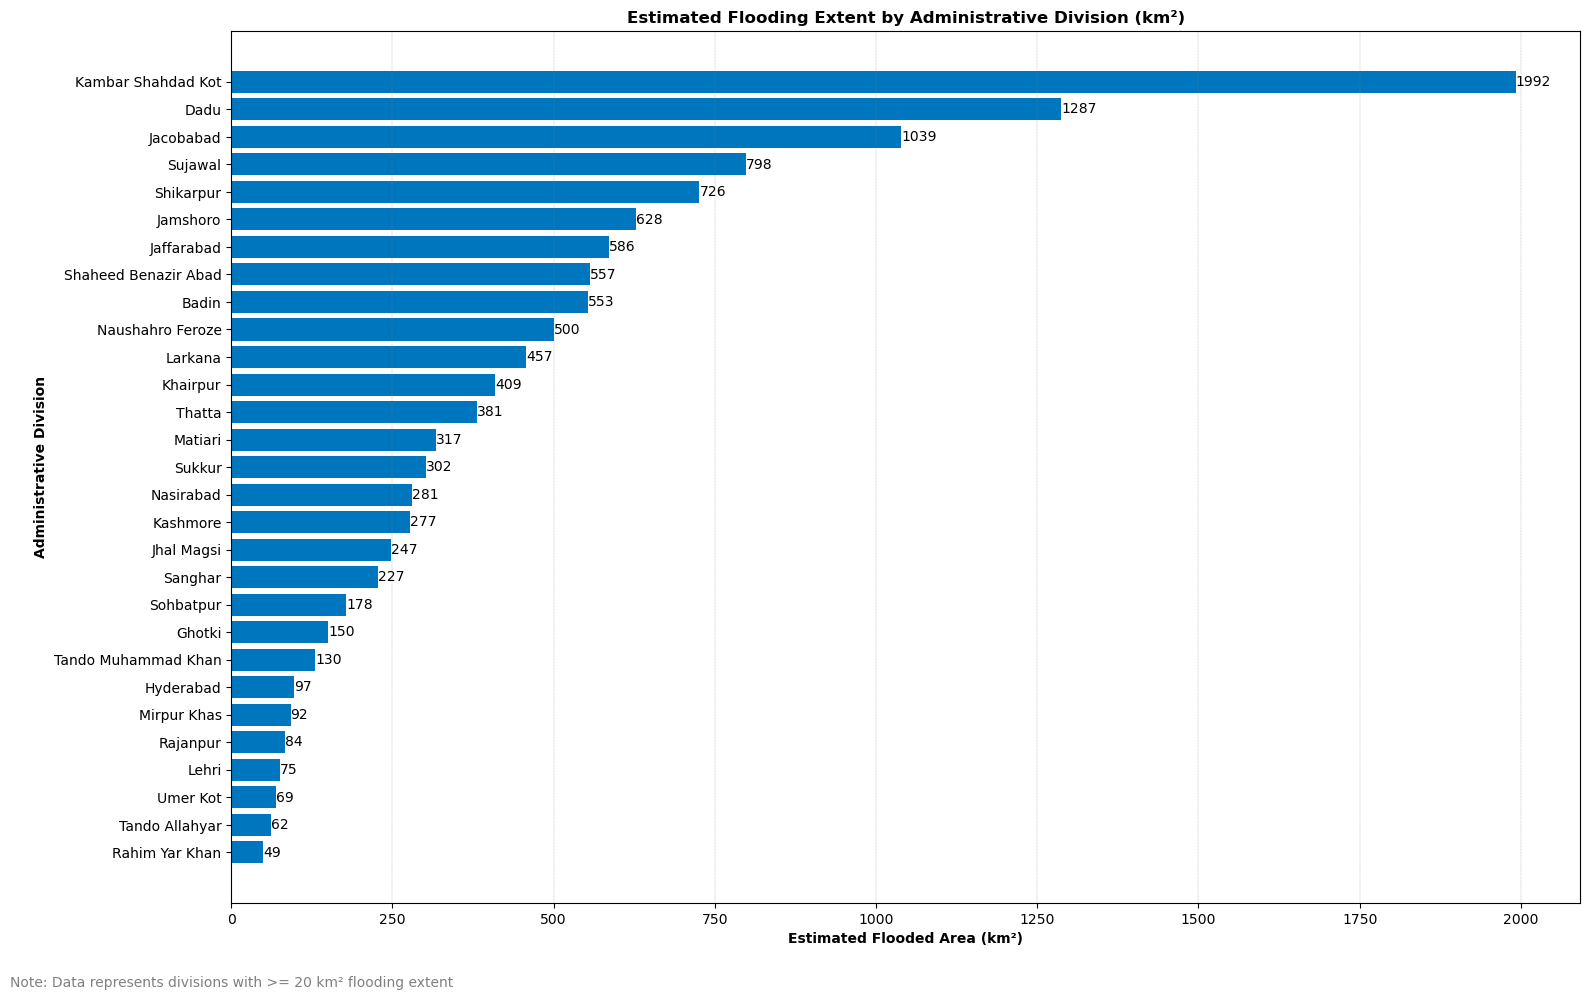

In [25]:
# Filter out divisions with flood extent less than 20km²
flood_filtered_df = df[df['flood_extent_km2'] >= 20]

# Sort the filtered dataframe in descending order of flood extent
flood_sorted_df = flood_filtered_df.sort_values(by='flood_extent_km2', ascending=True)

# Extract the sorted data
divisions = flood_sorted_df['ADM2_EN']
flood_extents = flood_sorted_df['flood_extent_km2']

# Create a horizontal bar chart
plt.figure(figsize=(16, 10))
bars = plt.barh(divisions, flood_extents, color='#0076be')

# Make axis labels and title
plt.ylabel('Administrative Division', fontweight='bold')
plt.xlabel('Estimated Flooded Area (km²)', fontweight='bold')
plt.title('Estimated Flooding Extent by Administrative Division (km²)', fontweight='bold')

# Adjust x and y axis ticks and add grid
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.2, color='gray')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2), 
             va='center', ha='left')
    
# Add a note to the graph
note = "Note: Data represents divisions with >= 20 km² flooding extent"
plt.text(0.56, -5, note, fontsize=10, ha='center', va='bottom', color='gray')

# Show the chart
plt.tight_layout()
plt.show()

#### 17.2. Chart estimated exposed population by division

Let's do the same for exposed population. The dataframe containing exposed population statistics is filtered to focus on divisions with more than 100 people exposed. This filtered data is then sorted in ascending order of population exposure for clarity in the chart. 

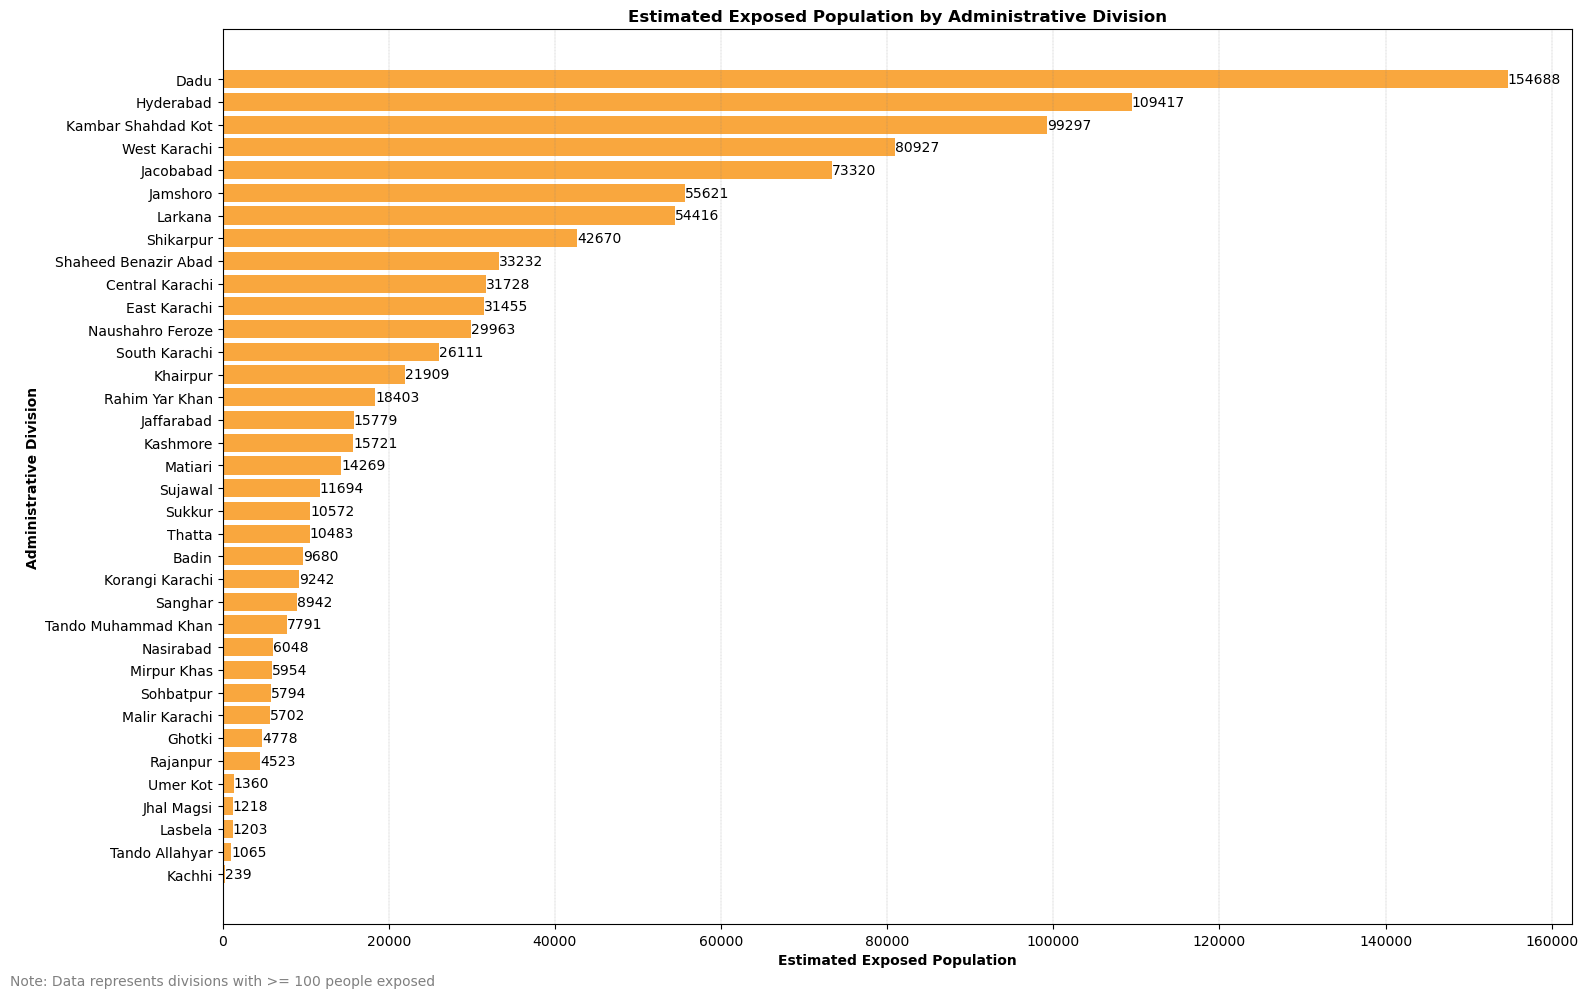

In [26]:
# Filter out divisions with exposed population of less than 100
pop_filtered_df = df[df['exposed_population'] >= 100]

# Sort the filtered dataframe in descending order of exposed cropland
pop_sorted_df = pop_filtered_df.sort_values(by='exposed_population', ascending=True)

# Extract the sorted data
divisions = pop_sorted_df['ADM2_EN']
exposed_pop = pop_sorted_df['exposed_population']

# Create a horizontal bar chart
plt.figure(figsize=(16, 10))
bars = plt.barh(divisions, exposed_pop, color='#f9a73e')

# Make axis labels and title
plt.ylabel('Administrative Division', fontweight='bold')
plt.xlabel('Estimated Exposed Population', fontweight='bold')
plt.title('Estimated Exposed Population by Administrative Division', fontweight='bold')

# Adjust x and y axis ticks and add grid
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.2, color='gray')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2), 
             va='center', ha='left')
    
# Add a note to the graph
note = "Note: Data represents divisions with >= 100 people exposed"
plt.text(0.56, -5, note, fontsize=10, ha='center', va='bottom', color='gray')

# Show the chart
plt.tight_layout()
plt.show()

#### 17.3. Chart estimated exposed cropland by division

Again, let's do the same for exposed cropland.

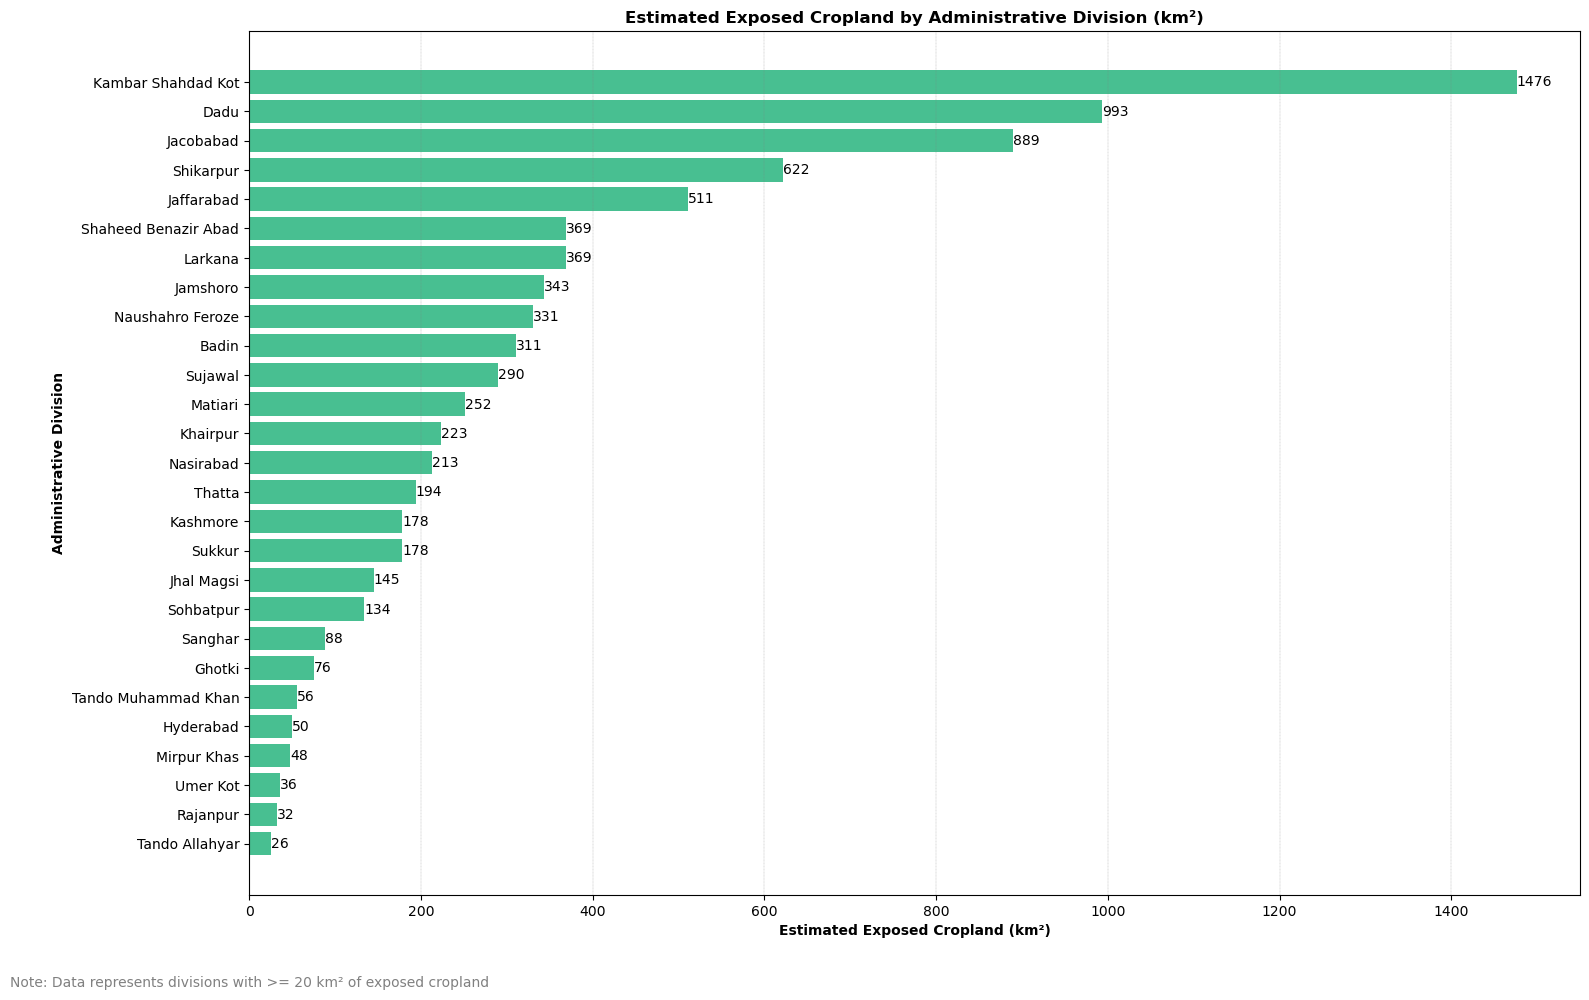

In [27]:
# Filter out divisions with less than 20km² exposed cropland
crop_filtered_df = df[df['exposed_cropland_km2'] >= 20]

# Sort the filtered dataframe in descending order of exposed cropland
crop_sorted_df = crop_filtered_df.sort_values(by='exposed_cropland_km2', ascending=True)

# Extract the sorted data
divisions = crop_sorted_df['ADM2_EN']
flood_extents = crop_sorted_df['exposed_cropland_km2']

# Create a horizontal bar chart
plt.figure(figsize=(16, 10))
bars = plt.barh(divisions, flood_extents, color='#48bf91')

# Make axis labels and title
plt.ylabel('Administrative Division', fontweight='bold')
plt.xlabel('Estimated Exposed Cropland (km²)', fontweight='bold')
plt.title('Estimated Exposed Cropland by Administrative Division (km²)', fontweight='bold')

# Adjust x and y axis ticks and add grid
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.2, color='gray')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2), 
             va='center', ha='left')
    
# Add a note to the graph
note = "Note: Data represents divisions with >= 20 km² of exposed cropland"
plt.text(0.56, -5, note, fontsize=10, ha='center', va='bottom', color='gray')

# Show the chart
plt.tight_layout()
plt.show()

#### 17.4. Chart the top 10 most affected divisions in terms of flood extent and exposed cropland

Here we create a horizontal bar chart that compares flood extents and exposed cropland areas in the top 10 most affected administrative divisions. 


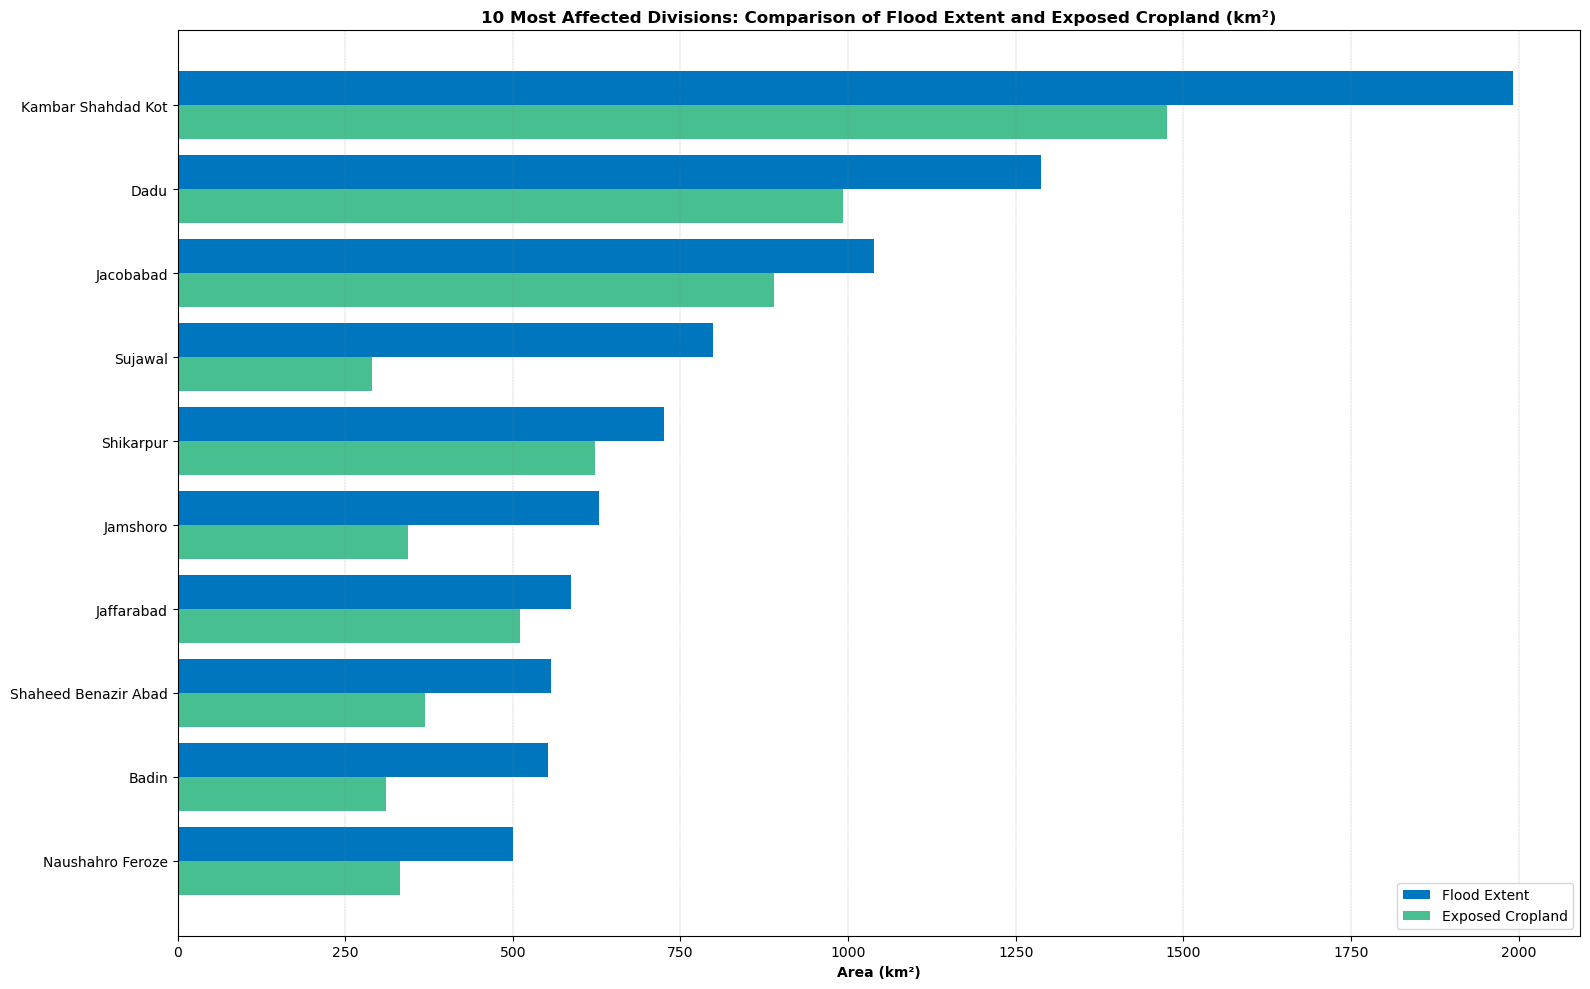

In [28]:
# Sort the dataframe by flood extent and select the top 10
top10_sorted_df = df.sort_values(by='flood_extent_km2', ascending=False).head(10)

# Extract the sorted data
divisions = top10_sorted_df['ADM2_EN']
flood_extents = top10_sorted_df['flood_extent_km2']
cropland_extents = top10_sorted_df['exposed_cropland_km2']

# Number of divisions
n_divisions = len(divisions)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(16, 10))

# Calculate bar positions
bar_width = 0.4
indices = np.arange(n_divisions)

# Plot the bars for each metric
ax.barh(indices - bar_width/2, flood_extents, height=bar_width, color='#0076be', label='Flood Extent')
ax.barh(indices + bar_width/2, cropland_extents, height=bar_width, color='#48bf91', label='Exposed Cropland')

# Set y-axis labels, ticks and grid
ax.set(yticks=indices, yticklabels=divisions)
ax.invert_yaxis() 
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.2, color='gray')

# Make axis labels and title
plt.xlabel('Area (km²)', fontweight='bold')
plt.title('10 Most Affected Divisions: Comparison of Flood Extent and Exposed Cropland (km²)', fontweight='bold')
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()

### 18. Join results dataframe to ADM2 geodataframe

Let's create a geodataframe with our flooding statistics dataframe. To do this we import a geojson file with the adm2 boundaries and join our flooding statistics dataframe based on the `ADM2_PCODE` columns in both data sets. We can also do a bit of data wrangling to clean up the resulting geodataframe. 

In [29]:
# Path to GeoJSON file
gjsn_path = "inputs/pak_adm2.geojson"

# Read GeoJSON file using Geopandas
gdf = gpd.read_file(gjsn_path)

# Join the DataFrame and GeoDataFrame
joined_df = pd.merge(df, gdf, on='ADM2_PCODE', how='left')

# Drop unnecessary columns
drop_list = ['ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN', 'date', 'validOn', 'validTo']
joined_df.drop(columns=drop_list, inplace=True, errors='ignore')
joined_df = joined_df[joined_df.columns.drop(list(joined_df.filter(regex='_y')))]

# Rename columns
joined_df.rename(columns={'ADM2_EN_x': 'ADM2_EN', 'ADM1_EN_x': 'ADM1_EN', 'ADM1_PCODE_x': 'ADM1_PCODE'}, inplace=True)

# Convert joined DataFrame to GeoDataFrame
final_gdf = gpd.GeoDataFrame(joined_df, geometry='geometry')

# Display GeoDataFrame
final_gdf

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,flood_extent_km2,flood_extent_ha,exposed_population,exposed_cropland_km2,exposed_cropland_ha,exposed_urban_km2,exposed_urban_ha,Shape_Leng,Shape_Area,ADM0_EN,ADM0_PCODE,geometry
0,Dera Bugti,PK204,Balochistan,PK2,6,645,5,3,277,0,0,5.132102,0.952769,Pakistan,PK,"MULTIPOLYGON (((69.56687 29.40586, 69.57153 29..."
1,Jaffarabad,PK207,Balochistan,PK2,586,58596,15779,511,51084,0,20,2.348028,0.156419,Pakistan,PK,"MULTIPOLYGON (((68.40644 28.44306, 68.41357 28..."
2,Jhal Magsi,PK208,Balochistan,PK2,247,24654,1218,145,14494,0,0,3.030243,0.355440,Pakistan,PK,"MULTIPOLYGON (((67.58710 28.82238, 67.58830 28..."
3,Kachhi,PK209,Balochistan,PK2,13,1312,239,0,49,0,0,4.676993,0.498322,Pakistan,PK,"MULTIPOLYGON (((67.21660 29.96277, 67.21751 29..."
4,Kalat,PK210,Balochistan,PK2,0,0,0,0,0,0,0,4.819595,0.943491,Pakistan,PK,"MULTIPOLYGON (((66.64471 29.44374, 66.64540 29..."
5,Khuzdar,PK213,Balochistan,PK2,2,177,62,0,3,0,0,9.862301,2.826250,Pakistan,PK,"MULTIPOLYGON (((67.25439 28.84063, 67.24799 28..."
6,Kohlu,PK216,Balochistan,PK2,0,0,0,0,0,0,0,5.494929,0.719640,Pakistan,PK,"MULTIPOLYGON (((69.47900 30.02680, 69.47516 30..."
7,Lasbela,PK217,Balochistan,PK2,10,1035,1203,1,80,0,15,11.873281,1.265273,Pakistan,PK,"MULTIPOLYGON (((66.42353 25.52556, 66.42255 25..."
8,Lehri,PK218,Balochistan,PK2,75,7499,75,8,769,0,0,3.241817,0.304225,Pakistan,PK,"MULTIPOLYGON (((68.09951 29.33923, 68.10122 29..."
9,Nasirabad,PK222,Balochistan,PK2,281,28073,6048,213,21265,0,8,2.842520,0.297470,Pakistan,PK,"MULTIPOLYGON (((68.43860 28.77787, 68.43882 28..."


### 19. Export to GeoJSON and CSV

We can export our results to a geojson file and a CSV for further analysis or map-making in GIS software such as QGIS or ArcGIS. 

In [30]:
# Export GeoDataFrame to GeoJSON
final_gdf.to_file("outputs/pak_adm2_flooding.geojson", driver='GeoJSON')

# Drop unnecessary columns for export to CSV
drop_list = ['Shape_Leng', 'geometry', 'Shape_Area']
joined_df.drop(columns=drop_list, inplace=True, errors='ignore')
final_csv = joined_df

# Export to CSV
final_csv.to_csv("outputs/pak_adm2_flooding.csv", index=False)

### 20. Export images to GeoTIFF

Finally, let's set up a series of exports to Google Drive, converting our flood extent, cropland, population, and urban images into GeoTIFF format. These exports will take quite a long time. Check your Drive account in a few hours. You can view the export progress in the [GEE tasks panel](https://code.earthengine.google.com/)

In [37]:
# Export flood extent to Google Drive as GeoTIFF
export_task1 = ee.batch.Export.image.toDrive(image=flooded,
                                            description='Export Flood Extent',
                                            folder='Pakistan_Flood_Analysis_GeoTIFFs',
                                            fileNamePrefix='Flood_Extent',
                                            scale=10,
                                            region=aoi, 
                                            maxPixels=1e13,
                                            crs='EPSG:4326',
                                            fileFormat='GeoTIFF',
                                            formatOptions={
                                                    'cloudOptimized': True
                                                })

# Export population exposed to Google Drive as GeoTIFF
export_task2 = ee.batch.Export.image.toDrive(image=population_exposed,
                                            description='Export Population Exposed',
                                            folder='Pakistan_Flood_Analysis_GeoTIFFs',
                                            fileNamePrefix='Population_Exposed',
                                            scale=100,
                                            region=aoi, 
                                            maxPixels=1e13,
                                            crs='EPSG:4326',
                                            fileFormat='GeoTIFF',
                                            formatOptions={
                                                    'cloudOptimized': True
                                                })

# Export cropland exposed to Google Drive as GeoTIFF
export_task3 = ee.batch.Export.image.toDrive(image=cropland_exposed,
                                            description='Export Cropland Exposed',
                                            folder='Pakistan_Flood_Analysis_GeoTIFFs',
                                            fileNamePrefix='Cropland_Exposed',
                                            scale=100,
                                            region=aoi, 
                                            maxPixels=1e13,
                                            crs='EPSG:4326',
                                            fileFormat='GeoTIFF',
                                            formatOptions={
                                                    'cloudOptimized': True
                                                })

# Export urban exposed to Google Drive as GeoTIFF
export_task4 = ee.batch.Export.image.toDrive(image=urban_exposed,
                                            description='Export Urban Exposed',
                                            folder='Pakistan_Flood_Analysis_GeoTIFFs',
                                            fileNamePrefix='Urban_Exposed',
                                            scale=100,
                                            region=aoi, 
                                            maxPixels=1e13,
                                            crs='EPSG:4326',
                                            fileFormat='GeoTIFF',
                                            formatOptions={
                                                    'cloudOptimized': True
                                                })

# Start the export tasks
export_task1.start()
export_task2.start()
export_task3.start()
export_task4.start()